# Value-at-Risk (VaR) Analysis Project
## Part 1: Data Collection and Exploratory Analysis

This notebook performs comprehensive data preparation and exploratory analysis for a multi-asset portfolio VaR calculation. We'll download historical price data, calculate returns, test distributional assumptions, and visualize key characteristics of our portfolio assets.

**Objectives:**
- Download 3 years of historical data for a diversified portfolio
- Calculate daily returns and assess statistical properties
- Test the normality assumption
- Identify extreme events and tail behavior
- Prepare clean datasets for VaR calculation

---

In [ ]:
pip install yfinance pandas numpy matplotlib scipy

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

## 1. Define Portfolio and Time Period

This portfolio consists of 5 assets representing different asset classes:
- **AAPL, MSFT**: Technology stocks (high growth, high volatility)
- **JPM**: Financial sector (cyclical, moderate volatility)
- **GLD**: Gold ETF (safe haven, low correlation with equities)
- **SPY**: S&P 500 ETF (broad market benchmark)

We use 3 years of data to capture different market conditions while maintaining relevance to current market dynamics.

In [2]:
# Define portfolio tickers
tickers = ['AAPL', 'MSFT', 'JPM', 'GLD', 'SPY']

# Define time period (3 years of historical data)
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

print(f"\n Portfolio Assets: {', '.join(tickers)}")
print(f"Data Period: {start_date.date()} to {end_date.date()}")


 Portfolio Assets: AAPL, MSFT, JPM, GLD, SPY
Data Period: 2022-11-05 to 2025-11-04


## 2. Download Historical Price Data

We download adjusted close prices for each asset individually to ensure data quality and handle any API issues gracefully. Adjusted prices account for splits and dividends, providing accurate return calculations.

**Data Quality Checks:**
- Verify successful download for each ticker
- Align dates across all assets (using concat)
- Handle missing values with forward fill
- Display sample data for verification

In [3]:
print("DOWNLOADING HISTORICAL PRICE DATA...")

# Download data for each ticker individually
data_list = []

for ticker in tickers:
    print(f"Downloading {ticker}...", end=" ")
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        # Check what columns are available and extract price data
        if not df.empty:
            if 'Adj Close' in df.columns:
                price_series = df['Adj Close']
            elif ('Close' in df.columns):
                price_series = df['Close']
            else:
                # If it's a single column, use it directly
                price_series = df.iloc[:, 0]
            
            # Rename the series to the ticker
            price_series.name = ticker
            data_list.append(price_series)
            print("Done")
        else:
            print("No data returned")
    except Exception as e:
        print(f"Error: {e}")

# Combine into a single DataFrame using concat
data = pd.concat(data_list, axis=1)
data = data.dropna()  # Remove any rows with missing data

# Check for missing data
print(f"Data downloaded successfully!")
print(f"Shape: {data.shape[0]} days × {data.shape[1]} assets")
print(f"Date Range: {data.index[0].date()} to {data.index[-1].date()}")

print("\nMissing Values Check:")
missing = data.isnull().sum()
if missing.sum() > 0:
    print(missing)
    print("\nApplying forward fill to handle missing values...")
    data = data.ffill()
    print("Missing values handled")
else:
    print("No missing values found!")

# Display sample data
print("\n" + "="*70)
print("FIRST 5 DAYS OF PRICE DATA")
print("="*70)
print(data.head().to_string())

print("\n" + "="*70)
print("LAST 5 DAYS OF PRICE DATA")
print("="*70)
print(data.tail().to_string())

DOWNLOADING HISTORICAL PRICE DATA...

C:\Users\MARWA I KHOT\AppData\Local\Temp\ipykernel_7568\740312053.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Done

C:\Users\MARWA I KHOT\AppData\Local\Temp\ipykernel_7568\740312053.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Done

C:\Users\MARWA I KHOT\AppData\Local\Temp\ipykernel_7568\740312053.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Done

C:\Users\MARWA I KHOT\AppData\Local\Temp\ipykernel_7568\740312053.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Done

C:\Users\MARWA I KHOT\AppData\Local\Temp\ipykernel_7568\740312053.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Done
Data downloaded successfully!
Shape: 751 days × 5 assets
Date Range: 2022-11-07 to 2025-11-04

Missing Values Check:
No missing values found!

FIRST 5 DAYS OF PRICE DATA
Ticker            AAPL        MSFT         JPM         GLD         SPY
Date                                                                  
2022-11-07  136.988037  222.339035  122.009422  155.850006  364.637573
2022-11-08  137.559952  223.314743  122.083717  159.449997  366.604950
2022-11-09  132.994370  219.060577  120.495583  158.649994  359.052124
2022-11-10  144.827484  237.082245  125.455070  163.479996  378.783569
2022-11-11  147.618118  241.112045  125.659401  164.559998  382.449585

LAST 5 DAYS OF PRICE DATA
Ticker            AAPL        MSFT         JPM         GLD         SPY
Date                                                                  
2025-10-29  269.700012  541.549988  305.510010  363.000000  687.390015
2025-10-30  271.399994  525.760010  309.440002  370.130005  679.830017
2025-10-31  270.3

## 3. Calculate Daily Returns

Daily returns are calculated as percentage changes

**Key Metrics:**
- **Mean Return**: Average daily performance
- **Standard Deviation**: Volatility/risk measure
- **Correlation Matrix**: Shows diversification benefits (lower correlation = better diversification)
- **Annualized Metrics**: Scaled to annual basis for intuitive interpretation (×252 for returns, ×√252 for volatility)

The Sharpe Ratio measures risk-adjusted returns (higher is better).

In [4]:
# Calculate daily returns (percentage change)
returns = data.pct_change().dropna()

print(f"Daily returns calculated!")
print(f"Total observations: {len(returns)}")

# Display basic statistics
print("\n" + "="*70)
print("RETURN STATISTICS (Daily)")
print("="*70)
print(returns.describe().to_string())

# Calculate and display correlation matrix
print("\n" + "="*70)
print("CORRELATION MATRIX")
print("="*70)
correlation = returns.corr()
print(correlation.round(3).to_string())

# Annualized metrics for context
print("\n" + "="*70)
print("ANNUALIZED METRICS (Approximate)")
print("="*70)
annual_return = returns.mean() * 252
annual_vol = returns.std() * np.sqrt(252)
sharpe = annual_return / annual_vol

metrics_df = pd.DataFrame({
    'Annual Return': annual_return,
    'Annual Volatility': annual_vol,
    'Sharpe Ratio': sharpe
})
print(metrics_df.to_string())

Daily returns calculated!
Total observations: 750

RETURN STATISTICS (Daily)
Ticker        AAPL        MSFT         JPM         GLD         SPY
count   750.000000  750.000000  750.000000  750.000000  750.000000
mean      0.001047    0.001229    0.001347    0.001186    0.000876
std       0.016969    0.015166    0.014414    0.010196    0.010069
min      -0.092456   -0.061809   -0.074838   -0.064269   -0.058543
25%      -0.007074   -0.006777   -0.005417   -0.004632   -0.003657
50%       0.001491    0.001195    0.001859    0.001148    0.000929
75%       0.009012    0.009279    0.008661    0.007052    0.005988
max       0.153288    0.101337    0.115445    0.036991    0.105019

CORRELATION MATRIX
Ticker   AAPL   MSFT    JPM    GLD    SPY
Ticker                                   
AAPL    1.000  0.541  0.331  0.071  0.723
MSFT    0.541  1.000  0.289  0.058  0.711
JPM     0.331  0.289  1.000 -0.018  0.608
GLD     0.071  0.058 -0.018  1.000  0.105
SPY     0.723  0.711  0.608  0.105  1.000

ANNUA

## 4. Visualize Price History

Time series plots reveal:
- Long-term trends and growth patterns
- Volatility regimes (periods of high/low fluctuation)
- Major market events (crashes, rallies)
- Relative performance across assets

The percentage change from start to end provides a quick performance summary.

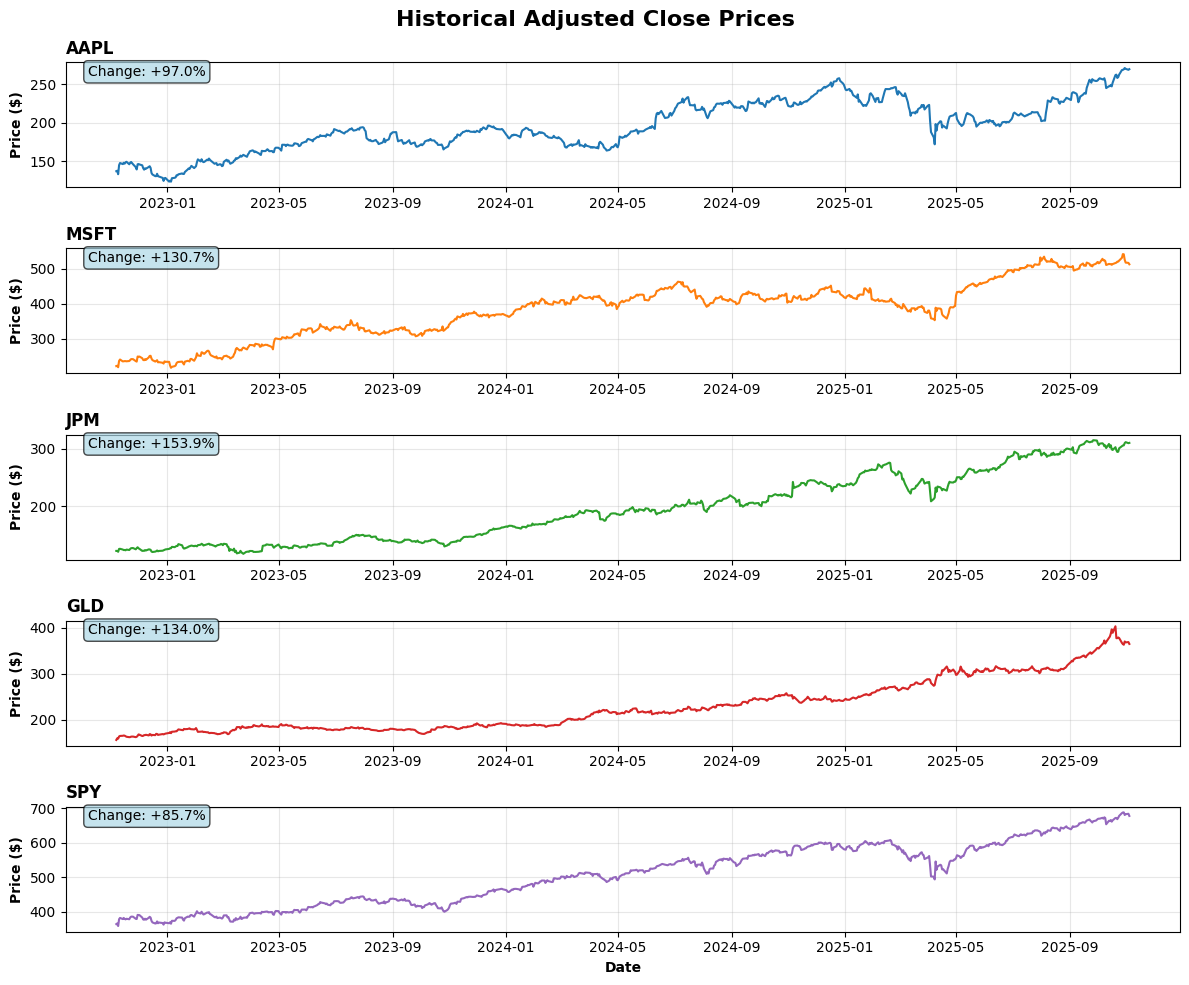

Chart saved: '01_price_history.png'


In [5]:
# Plot historical prices
fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 10))
fig.suptitle('Historical Adjusted Close Prices', fontsize=16, fontweight='bold')

if len(tickers) == 1:
    axes = [axes]

for i, ticker in enumerate(tickers):
    axes[i].plot(data.index, data[ticker], linewidth=1.5, color=f'C{i}')
    axes[i].set_ylabel('Price ($)', fontweight='bold')
    axes[i].set_title(ticker, fontweight='bold', loc='left')
    axes[i].grid(True, alpha=0.3)
    
    # Add summary statistics
    current_price = data[ticker].iloc[-1]
    start_price = data[ticker].iloc[0]
    pct_change = ((current_price - start_price) / start_price) * 100
    axes[i].text(0.02, 0.98, f'Change: {pct_change:+.1f}%', 
                 transform=axes[i].transAxes, 
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

axes[-1].set_xlabel('Date', fontweight='bold')
plt.tight_layout()
plt.savefig('01_price_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved: '01_price_history.png'")

## 5. Analyze Return Distributions

**Critical for VaR:** The distribution shape determines which VaR method is most appropriate.

**Left Panel - Histogram:**
- Blue bars: Actual return distribution
- Red curve: Normal distribution overlay (theoretical)
- Green line: Mean return

**Right Panel - Q-Q Plot:**
- Tests normality visually
- Points on diagonal = normal distribution
- Deviations indicate non-normality (fat tails, skewness)

**Key Statistics:**
- **Skewness**: Asymmetry (negative = more left tail losses)
- **Kurtosis**: Tail thickness (>3 = fatter tails than normal, more extreme events)

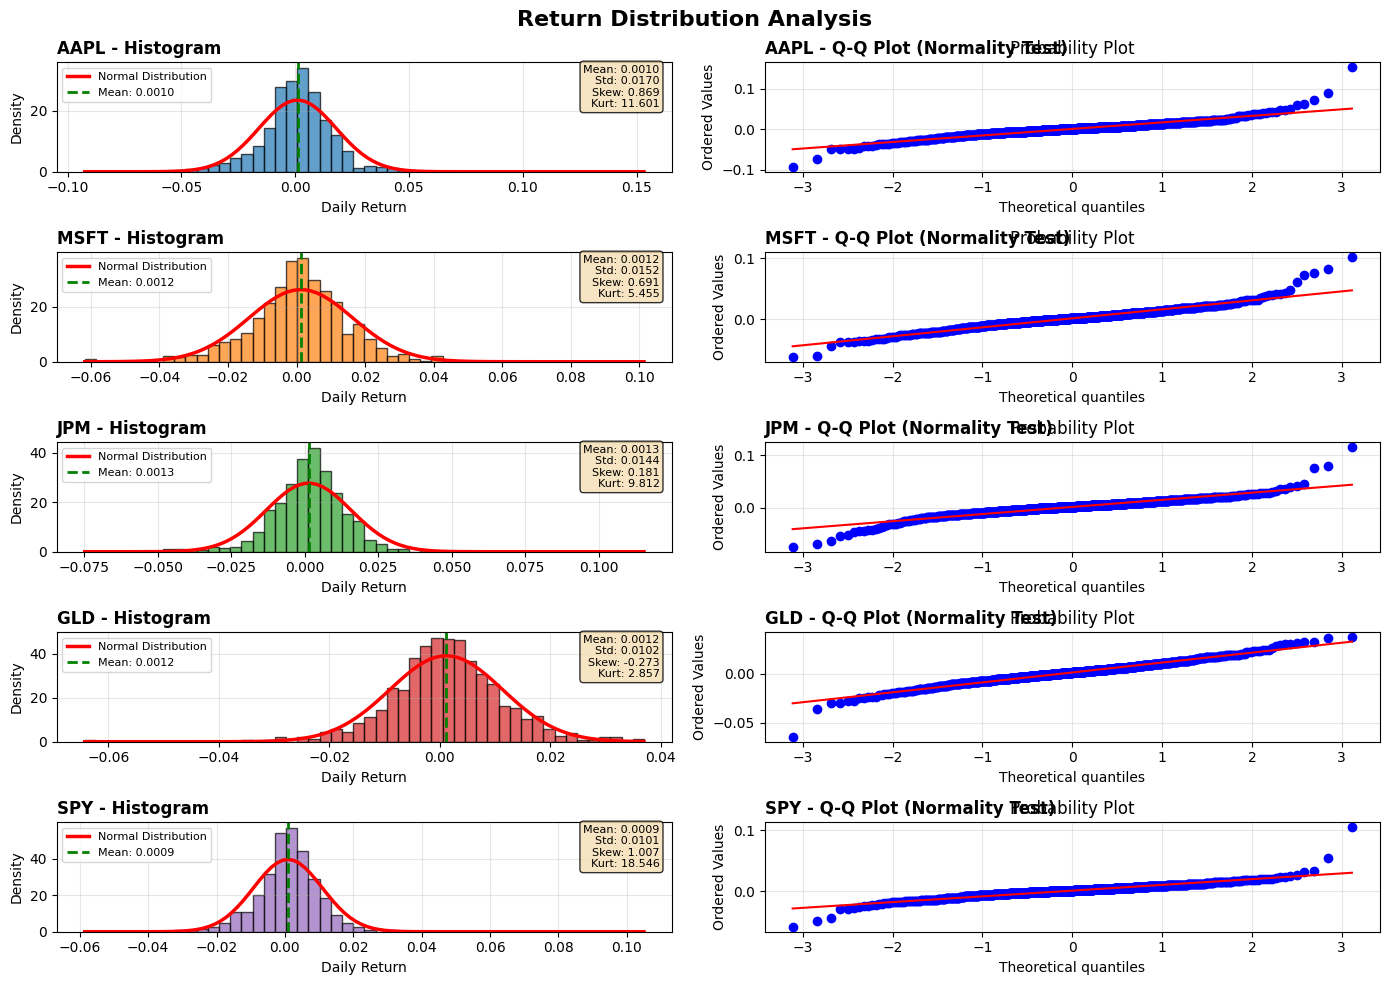

Chart saved: '02_return_distributions.png'


In [6]:
# Create comprehensive distribution analysis
fig, axes = plt.subplots(len(tickers), 2, figsize=(14, 10))
fig.suptitle('Return Distribution Analysis', fontsize=16, fontweight='bold')

if len(tickers) == 1:
    axes = axes.reshape(1, -1)

for i, ticker in enumerate(tickers):
    # Get returns for this asset
    asset_returns = returns[ticker]
    
    # LEFT COLUMN: Histogram with Normal Overlay
    ax1 = axes[i, 0]
    
    # Plot histogram
    n, bins, patches = ax1.hist(asset_returns, bins=50, density=True, 
                                  alpha=0.7, color=f'C{i}', edgecolor='black')
    
    # Fit and plot normal distribution
    mu, sigma = asset_returns.mean(), asset_returns.std()
    x = np.linspace(asset_returns.min(), asset_returns.max(), 100)
    normal_curve = stats.norm.pdf(x, mu, sigma)
    ax1.plot(x, normal_curve, 'r-', linewidth=2.5, label='Normal Distribution')
    
    # Add vertical line at mean
    ax1.axvline(mu, color='green', linestyle='--', linewidth=2, label=f'Mean: {mu:.4f}')
    
    # Calculate and display statistics
    skewness = asset_returns.skew()
    kurtosis = asset_returns.kurtosis()
    
    # Labels and legend
    ax1.set_title(f'{ticker} - Histogram', fontweight='bold', loc='left')
    ax1.set_xlabel('Daily Return')
    ax1.set_ylabel('Density')
    ax1.legend(loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f'Mean: {mu:.4f}\nStd: {sigma:.4f}\nSkew: {skewness:.3f}\nKurt: {kurtosis:.3f}'
    ax1.text(0.98, 0.98, stats_text,
             transform=ax1.transAxes, 
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=8)
    
    # RIGHT COLUMN: Q-Q Plot (tests normality)
    ax2 = axes[i, 1]
    stats.probplot(asset_returns, dist="norm", plot=ax2)
    ax2.set_title(f'{ticker} - Q-Q Plot (Normality Test)', fontweight='bold', loc='left')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_return_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved: '02_return_distributions.png'")

## 6. Formal Normality Tests

Statistical tests to formally assess the normality assumption:

**Jarque-Bera Test:**
- Tests for skewness and kurtosis
- More sensitive to large samples
- H₀: Data is normally distributed

**Shapiro-Wilk Test:**
- General normality test
- Considered more powerful for smaller samples

**Interpretation:**
- p-value < 0.05 → Reject normality (use historical or Monte Carlo VaR)
- p-value ≥ 0.05 → Accept normality (parametric VaR may be appropriate)

Most financial returns exhibit **fat tails** and are **not normally distributed**, which has important implications for VaR accuracy.

In [7]:
print("Testing H0: Returns follow a normal distribution")
print("(p-value < 0.05 → Reject normality)")
print("-"*70)

normality_results = []

for ticker in tickers:
    asset_returns = returns[ticker]
    
    # Jarque-Bera test
    jb_stat, jb_pvalue = stats.jarque_bera(asset_returns)
    
    # Shapiro-Wilk test
    if len(asset_returns) > 5000:
        sample = asset_returns.sample(5000, random_state=42)
        sw_stat, sw_pvalue = stats.shapiro(sample)
    else:
        sw_stat, sw_pvalue = stats.shapiro(asset_returns)
    
    # Determine result
    is_normal = "ACCEPT" if jb_pvalue >= 0.05 else "REJECT"
    
    print(f"\n{ticker}:")
    print(f"  Jarque-Bera:  stat={jb_stat:8.2f}, p-value={jb_pvalue:.4f}")
    print(f"  Shapiro-Wilk: stat={sw_stat:8.4f}, p-value={sw_pvalue:.4f}")
    print(f"  → {is_normal} normality assumption (α=0.05)")
    
    normality_results.append({
        'Ticker': ticker,
        'JB_stat': jb_stat,
        'JB_pvalue': jb_pvalue,
        'Normal?': is_normal
    })

# Create summary table
normality_df = pd.DataFrame(normality_results)

Testing H0: Returns follow a normal distribution
(p-value < 0.05 → Reject normality)
----------------------------------------------------------------------

AAPL:
  Jarque-Bera:  stat= 4238.29, p-value=0.0000
  Shapiro-Wilk: stat=  0.9055, p-value=0.0000
  → REJECT normality assumption (α=0.05)

MSFT:
  Jarque-Bera:  stat=  974.35, p-value=0.0000
  Shapiro-Wilk: stat=  0.9423, p-value=0.0000
  → REJECT normality assumption (α=0.05)

JPM:
  Jarque-Bera:  stat= 2967.99, p-value=0.0000
  Shapiro-Wilk: stat=  0.8960, p-value=0.0000
  → REJECT normality assumption (α=0.05)

GLD:
  Jarque-Bera:  stat=  259.54, p-value=0.0000
  Shapiro-Wilk: stat=  0.9766, p-value=0.0000
  → REJECT normality assumption (α=0.05)

SPY:
  Jarque-Bera:  stat=10723.02, p-value=0.0000
  Shapiro-Wilk: stat=  0.8809, p-value=0.0000
  → REJECT normality assumption (α=0.05)


## 7. Identify Extreme Events

Examining the most extreme returns helps us:
- Identify historical crash/rally events
- Assess tail risk magnitude
- Validate that our data captures crisis periods
- Understand the limitations of normal distribution assumptions

These extreme events are crucial for backtesting VaR models.

In [8]:
for ticker in tickers:
    asset_returns = returns[ticker]
    
    # Find top 5 best and worst days
    best_days = asset_returns.nlargest(5)
    worst_days = asset_returns.nsmallest(5)
    
    print(f"\n{ticker}:")
    print(f"  Best 5 days:  {best_days.iloc[0]:.4f} to {best_days.iloc[-1]:.4f}")
    print(f"  Worst 5 days: {worst_days.iloc[0]:.4f} to {worst_days.iloc[-1]:.4f}")


AAPL:
  Best 5 days:  0.1533 to 0.0598
  Worst 5 days: -0.0925 to -0.0482

MSFT:
  Best 5 days:  0.1013 to 0.0616
  Worst 5 days: -0.0618 to -0.0376

JPM:
  Best 5 days:  0.1154 to 0.0412
  Worst 5 days: -0.0748 to -0.0519

GLD:
  Best 5 days:  0.0370 to 0.0309
  Worst 5 days: -0.0643 to -0.0282

SPY:
  Best 5 days:  0.1050 to 0.0260
  Worst 5 days: -0.0585 to -0.0291


## 8. Save Processed Data

We save cleaned datasets for use in subsequent VaR calculations:
- **cleaned_returns.csv**: Daily returns (primary input for VaR)
- **cleaned_prices.csv**: Price history (for reference and visualization)
- **normality_tests.csv**: Test results (guides VaR method selection)

---

In [9]:
# Save cleaned data
returns.to_csv('cleaned_returns.csv')
data.to_csv('cleaned_prices.csv')
normality_df.to_csv('normality_tests.csv', index=False)

print("Files saved:")
print("   - cleaned_returns.csv")
print("   - cleaned_prices.csv")
print("   - normality_tests.csv")

Files saved:
   - cleaned_returns.csv
   - cleaned_prices.csv
   - normality_tests.csv
